In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import models, transforms
from tqdm import tqdm
import pandas as pd
import nltk
import string
from nltk.corpus import stopwords
from transformers import BertTokenizer

nltk.download('stopwords')
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)


PyTorch Version:  2.0.0+cu118
Torchvision Version:  0.15.1+cu118
cpu


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:

batch_size = 8

max_len = 431
# Chargement du tokenizer et du modèle BERT

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)



In [12]:

test = pd.read_json("/content/drive/MyDrive/data/val.jsonl",lines=True)

del test['id']


def punctuation(df, column, new_column):
  df[new_column]=df[column].apply(lambda x: "".join([char for char in x if char not in string.punctuation]))
  return df

In [13]:
cleaned_test = punctuation(test, 'text', 'cleaned_text')
del cleaned_test['text']

In [14]:
from sklearn.model_selection import train_test_split

test_df = cleaned_test

print(f'Test dataset size: {len(test_df)}')


Test dataset size: 500


In [15]:
import torch
from PIL import Image

class MyDataset(torch.utils.data.Dataset):
  'Caractérise un jeu de données pour PyTorch'
  def __init__(self, transforms = None, root_dir = '/content/drive/MyDrive/data', mode = 'test', tokenizer = tokenizer):
        'Initialisation'
       
        self.df = test_df
        self.labels = self.df.label
        self.image_names = self.df.img
        self.transforms = transforms
        self.root_dir = root_dir
        self.texts = [tokenizer(sentence, padding='max_length', max_length = max_len, truncation=True, return_tensors="pt") for sentence in self.df['cleaned_text']]

#        print(len(self.labels[self.labels == 0])/len(self.labels))
      
  def __len__(self):
        "Représente le nombre total d'exemples du jeu de données"
        return len(self.labels)

  def __getitem__(self, idx):
      'Génère un exemple à partir du jeu de données'
      # Sélection de l'exemple

      image_path = f"{self.root_dir}/{self.image_names.iloc[idx]}"

      img = Image.open(image_path, ).convert('RGB')

      if self.transforms :
            img = self.transforms(img)

      

      return self.texts[idx], img, self.labels.iloc[idx]
  


In [16]:
# Data augmentation and normalization for training
# Just normalization for validation
input_size = 224
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: MyDataset(transforms = data_transforms[x], mode = x) for x in ['test']}

# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['test']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [17]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
    else :
        for param in model.parameters():
            param.requires_grad = True

def initialize_model( feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    model_ft = models.resnet18(pretrained=use_pretrained)
    
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 1)
    set_parameter_requires_grad(model_ft, feature_extract)
    return model_ft

In [18]:
from torch import nn
from transformers import BertForSequenceClassification
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2, output_attentions = False, output_hidden_states = False)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input_id, mask):

        bert_output = self.bert(input_ids = input_id, attention_mask = mask)
        logits = bert_output.logits          # pour obtenir le tensor en sortie de bert
        final_output = self.dropout(logits)  # pour réduire l'overfitt, ici p = 0.5

        return logits

In [19]:
# définir le modèle Bert
bert_model = BertClassifier()
bert_model.load_state_dict(state_dict = torch.load('/content/drive/MyDrive/data/best_model_sigm(3).pth', map_location=torch.device('cpu')))

# définir le modèle ResNet18
resnet18_model = initialize_model( feature_extract= True )
resnet18_model.load_state_dict(torch.load('/content/drive/MyDrive/data/best_model.pth'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

<All keys matched successfully>

In [72]:
# définir une classe de modèle qui effectue la moyenne des sorties des deux modèles
class LateFusionModel(torch.nn.Module):
    def __init__(self, bert_model, resnet18_model):
        super(LateFusionModel, self).__init__()
        self.bert_model = bert_model
        self.resnet18_model = resnet18_model
        set_parameter_requires_grad(self.bert_model ,True)
        set_parameter_requires_grad(self.resnet18_model ,True)
        
    def forward(self, input_ids, attention_mask, image):
        bert_output = self.bert_model(input_id=input_ids, mask=attention_mask)
        resnet_output = self.resnet18_model(image)
        resnet_output = (bert_output[:,1] + resnet_output.squeeze()).unsqueeze(dim =1)
        return resnet_output


In [71]:
tensor = torch.tensor([[ 1.9749, -1.9395],
                       [ 2.0307, -1.9026],
                       [ 0.1926, -0.2047],
                       [ 2.8160, -2.7805],
                       [ 0.5091, -0.5030],
                       [-0.3939,  0.3295],
                       [ 1.1195, -1.0223],
                       [ 3.6302, -3.4662]])
tensor1 = torch.tensor([[ 0.1855],
                       [-0.0101],
                       [-0.4516],
                       [ 0.0057],
                       [ 0.0227],
                       [ 0.2344],
                       [-0.8016],
                       [-0.2105]])
(tensor[:,1] + tensor1.squeeze()).unsqueeze(dim = 1)

tensor([[-1.7540],
        [-1.9127],
        [-0.6563],
        [-2.7748],
        [-0.4803],
        [ 0.5639],
        [-1.8239],
        [-3.6767]])

In [73]:
# initialiser une instance de ConcatBertModel
Late_Fusion = LateFusionModel(bert_model, resnet18_model)
Late_Fusion = Late_Fusion.to(device)
print(Late_Fusion)

LateFusionModel(
  (bert_model): BertClassifier(
    (bert): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (output): BertSelfOu

In [67]:
def test_late_fusion(model, dataloaders, criterion):

    val_acc_history = []

    running_loss = 0.0
    running_corrects = 0
    running_TP = 0.0
    running_FP = 0.0
    running_TN = 0.0
    running_FN = 0.0
    for input_ids, inputs, labels in tqdm(dataloaders['test']):
        TP=FP=TN=FN=0
        inputs = inputs.to(device)
        input_id = input_ids['input_ids'].squeeze(1).to(device)
        mask = input_ids['attention_mask'].to(device)

        labels = labels.to(device)
        outputs = model(input_id, mask, inputs)
        loss = criterion(outputs, labels.float().unsqueeze(1).to(device))
                
             
                  
        preds = (outputs > 0.5).float()
        for i in range(len(preds)) :
            if preds[i]== 1 and labels[i]==1 : TP+=1
            elif preds[i]== 1 and labels[i]==0 : FP+=1
            elif preds[i]== 0 and labels[i]==0 : TN+=1
            elif preds[i]== 0 and labels[i]==1 : FN+=1
                    

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.float().unsqueeze(1))
        running_TP += TP
        running_FP += FP
        running_TN += TN
        running_FN += FN
    epoch_loss = running_loss / len(dataloaders['test'].dataset)
    epoch_acc = running_corrects.double() / len(dataloaders['test'].dataset)
    epoch_recall = running_TP / (running_TP + running_FN) # recall
    epoch_specificity = running_TN / (running_TN + running_FP)
    print('{} Loss: {:.4f} Acc: {:.4f} Recall: {:.4f} Specificity: {:.4f}'.format('test', epoch_loss, epoch_acc, epoch_recall, epoch_specificity))
            

    return model, val_acc_history

In [23]:
loss = nn.BCEWithLogitsLoss()

In [77]:
Late_Fusion, hist = test_late_fusion(Late_Fusion, dataloaders_dict, loss)

  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 63/63 [17:16<00:00, 16.45s/it]

test Loss: 0.8551 Acc: 0.5500 Recall: 0.1680 Specificity: 0.9320


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


AUC-ROC : 0.6350


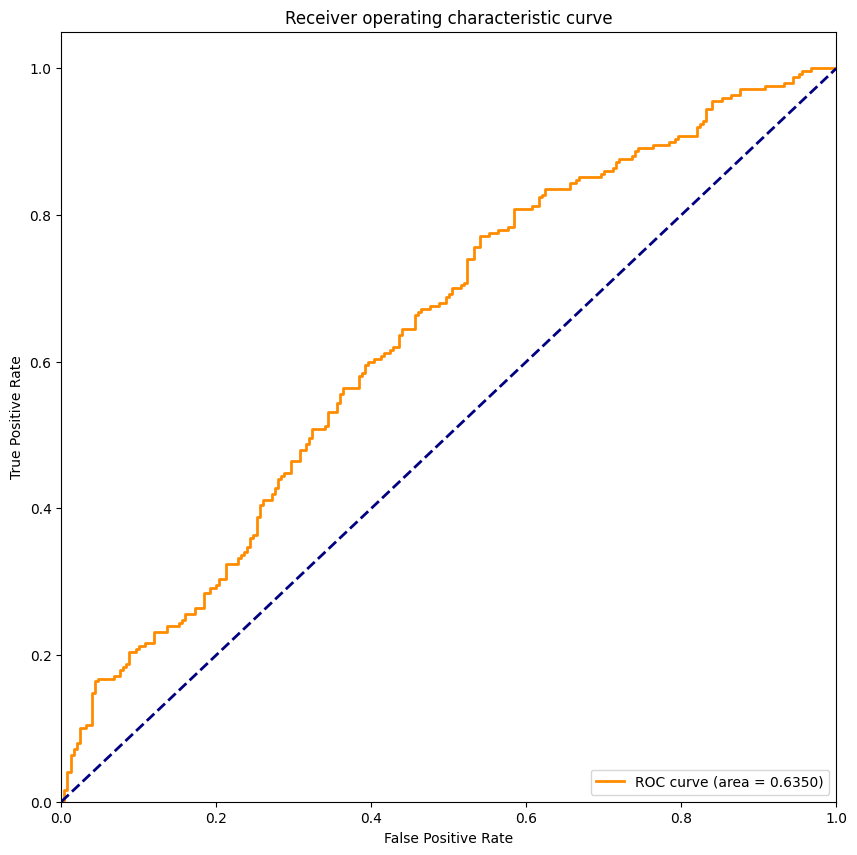

In [76]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score



# Prédire les probabilités pour les données de test
Late_Fusion.eval()
with torch.no_grad():
    y_pred = []
    y_true = []
    for input_ids, inputs, labels in dataloaders_dict['test']:
        inputs = inputs.to(device)
        input_id = input_ids['input_ids'].squeeze(1).to(device)
        mask = input_ids['attention_mask'].to(device)

        labels = labels
              
        outputs = Late_Fusion(input_id, mask, inputs)

        y_pred.extend(torch.sigmoid(outputs).cpu().numpy())
        y_true.extend(labels.numpy())


# Calculer l'AUC-ROC
auc_roc = roc_auc_score(y_true, y_pred)
print("AUC-ROC : {:.4f}".format(auc_roc))

# Calculer la courbe ROC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()